# Planning for Logistics

<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S45_logistics_planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()
import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

from gtbook import logistics

> Our warehouse robot needs to know its location in the warehouse with more precision than the vacuuming robot.

<img src="Figures4/S45-Warehouse_robots-05.jpg" alt="Splash image with warehouse robot thinking" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

In Chapter 3, we modeled a robot system as an MDP, and saw how to compute both
the optimal value function and the corresponding optimal policy.
The state space in Chapter 3 was very simple, having only five states.
For our vacuuming robot, it was sufficient to know the room in which the
robot was located, but this level of detail is not sufficient for our warehouse
robot.
In order to position itself accurately with respect to the shelves that
contain inventory, the warehouse robot needs a quantitative description
of its location, namely, coordinates in a warehouse coordinate frame.
Therefore, for our warehouse robot, we represent
the state space by a discrete grid, whose coordinates
define the location of the robot.
This representation has significantly more states than for the vacuuming robot.
In this section, we show how to perform value iteration on such a grid, and
briefly discuss the implications of estimating the state using sensor data.


## Value Iteration in 2D

```{index} planning; value iteration
```
> It works, but can be slow.

```{index} optimal value function
```
Recall from [Section 3.4](#sec:value-iteration) that *value iteration* approximates the optimal value function $V^*$ by constructing a sequence of estimates. The algorithm starts with an initial guess, $V^0$, and at each iteration we update
our approximation of the value function by the update rule:
\begin{equation}
V^{k+1}(x) \leftarrow \max_a \left\{ \bar{R}(x,a) + \gamma \sum_{x'} P(x'|x, a) V^k(x')   \right\}
= \max_a Q(x, a; V^k)
\end{equation}
This can be *very* expensive if applied naively when the number of states is large. Consider an example where
- we use the 5000-state finite element discretization of the warehouse,
- we discretize the action space to just moving in the 4 principal directions.

{raw:tex}`\noindent`
In this case, the conditional probability table (CPT) above contains $5k \times 4 \times 5k = 100M$ entries.

There are ways to deal with this computationally. Indeed, most transitions have zero probability, and hence we could store the CPT in a *sparse* multi-dimensional array instead. Alternatively, we can implement the Q value calculation as a *function*, which is the approach we adopt here. The code in Figure [1](#fig:warehouse-value-iteration) uses the 2D coordinates $(i,j)$ for the discretized cells, and implements the function $Q(x, a; V^k)$ from above in  the `Q_value` function: it *deterministically* calculates the `next` state and the reward $\bar{R}(x,a)$, and combines the reward with the discounted value $\gamma V^k(x')$ of the next state.

In [2]:
#| caption: Value iteration for the warehouse example.
#| label: fig:warehouse-value-iteration
goal = 35, 50
proximity = logistics.base_map + logistics.proximity_map_on

def Q_value(x, a, V):
    """Given a state x=(i,j) action a, and value image, calculate Q value."""
    i, j = x
    if x==goal: return 0 # only reward when *first* arriving at goal
    if logistics.base_map[i,j]: return 0 # invalid state
    if a == 0: next = (i,j-1) if j>0  else x # LEFT
    if a == 1: next = (i,j+1) if j<99 else x # RIGHT
    if a == 2: next = (i-1,j) if i>0  else x # UP
    if a == 3: next = (i+1,j) if i<49 else x # DOWN
    reward = 100 if next==goal else 0
    r, c = next
    if logistics.proximity_map_on[i,j]: reward -= 50 # in proximity is bad!
    if logistics.proximity_map_on[r,c]: reward -= 50 # as is going in proximity.
    return reward + 0.975 * V[r,c]

def update_V(x, V):
    """Given a state x=(i,j) and value image, calculate updated value."""
    Q_x = [Q_value(x, a, V) for a in range(4)]
    return max(Q_x)

Note that while here we assumed actions are deterministic, the function can be easily adapted to non-deterministic actions. We awarded 100 points upon reaching the goal, but make sure that happens only once. In addition, when the state is near an obstacle (we use the `proximity_map_on` likelihood image from Section 4.3), the agent gets punished by 100 points.

after 86 iterations, error = 0.0


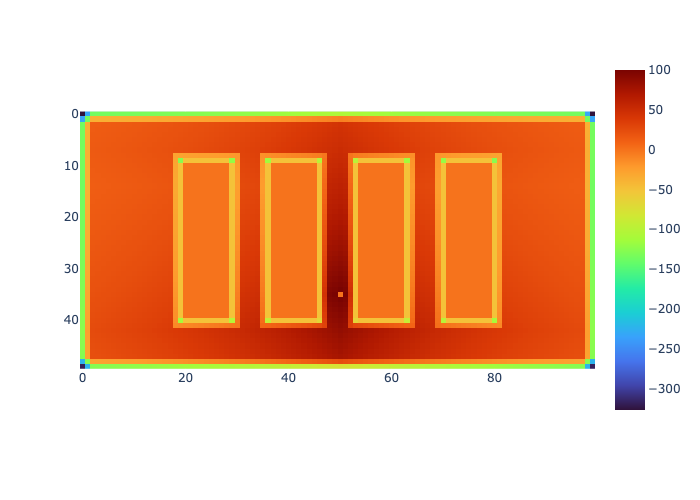

In [6]:
#| caption: The converged value function.
#| label: fig:converged-value-function
I, J = np.meshgrid(range(50), range(100), indexing='ij')
states = np.dstack((I, J)).reshape(5000,2)
k = 0
V_k = np.full((50,100), 0.0)
error = float('inf')
while error>1e-5:
    V_plus = np.empty((50,100), float)
    for i,j in states:
        V_plus[i,j] = update_V((i,j), V_k)
    error = np.max(np.abs(V_plus-V_k))
    V_k = V_plus
    k += 1
print(f"after {k} iterations, error = {error}")
px.imshow(V_k, color_continuous_scale='Turbo',origin="upper", aspect='equal')

In Figure [2](#fig:converged-value-function), we do value iteration using a brute force loop, which is still remarkably fast.
The "gradient" of the value function determines the optimal policy: at any cell, we can just look around in all 4 directions and move to the cell with the largest value. Caveat: there is really no continuous gradient because we discretized the actions: the figure only *looks* smooth because we used a fine resolution.

### Exercises

1. Why might the algorithm terminate after 86 iterations?
2. How would you modify the algorithm to take into account probabilistic actions?

## The Intuition behind Value Iteration

> Costs and rewards propagate.

<figure id="fig:value-animation">
<img src="https://github.com/gtbook/robotics/blob/main/Figures4/value.gif?raw=1" style="width:14cm" alt="">
<figcaption>The <b>value iteration</b> algorithm, animated.</figcaption>
</figure>

It is instructive to look at an animation, shown in Figure [3](#fig:value-animation), of how the value function evolves in successive iterations of the value iteration algorithm.
The most prominent phenomenon that one can see in the animation is that the goal reward (in the middle of the warehouse), gradually propagates towards every location. The reward gradually decreases in value because of the discount factor. It also does not penetrate the obstacles in the map, because those states simply have a value of zero.

In every iteration of value iteration each state re-evaluates its own value. The state next to the goal state "know" from the start that they are high value, but this will only be known to *their* neighbors in the next iteration.
Hence, it takes time for this information, modified by the discount factor, to reach all corners of the state space.

There is a deep connection between value iteration and the all-source-shortest-path algorithm that you might have seen in an algorithms class.
Deterministic actions set up a graph, and while in this case we have no penalty for moving in the graph, the discount factor plays the same role in practice.
In fact, if we set the discount factor to zero and give actions a cost, both algorithms will return identical results.

## Closing the Loop

> Adding a state estimator closes the sense-think-act loop.

When the robot acts in the world, it senses, estimates its state, and executes a policy. We can take any of the perception algorithms from the last section and use them to estimate the robot's current state. The value function gives us a policy, which the robot can then execute. After that, repeat.

To calculate the policy, we should take into account the uncertainty in actions. The policy we calculated above for the warehouse may not be optimal, because we assumed deterministic actions in the calculation of the Q values. In Section 3.5 we saw how to account for uncertain, Gaussian actions.
We could do the same here to potentially obtain a better policy.
In particular, the robot will be more cautious and stay even further away from obstacles,
since the robot does not always perfectly execute commands.

### Thought Exercise

Estimating a single location for the robot is not always possible: posterior densities can be *multi-modal*, and so the robot may not know any better than that it is in one of a number of possible locations. What should we do in that case?

## Partially Observable MDPs

> POMDPs facilitate planning to sense.

```{index} pair: partially observable Markov decision process; POMDP
```
To *really* calculate the optimal policy, we would need to know how future actions
will affect sensing. Even when we take into account the uncertainty in the actions, there is something we have not taken into account: uncertain *sensing*. Indeed, when calculating the optimal policy we have assumed that we have perfect knowledge of the state. The probabilistic model that takes into account uncertain sensing is called a **partially observable Markov decision process**, or **POMDP**. 

While out of scope for this book, it is important to be aware of this limitation of the MDP framework. A POMDP policy could improve on this by planning to sense: for example, the robot could deliberately move closer to an RFID beacon on purpose, to re-localize the robot when it is not very certain about its location. 

POMDPs are computationally incredibly expensive, because the state is no longer simply *where* we are, but also *what we believe* the state is. Hence, POMDPs are about planning in the *belief space*, which is a very high-dimensional concept.